In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ROOT import TH1D, TH2D, TCanvas
from itertools import combinations
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

Welcome to JupyROOT 6.22/08


# Boston dataset
### features are as below:
- CRIM:     per capita crime rate by town
- ZN:       proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS:    proportion of non-retail business acres per town
- CHAS:     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX:      nitric oxides concentration (parts per 10 million)
- RM:       average number of rooms per dwelling
- AGE:      proportion of owner-occupied units built prior to 1940
- DIS:      weighted distances to five Boston employment centres
- RAD:      index of accessibility to radial highways
- TAX:      full-value property-tax rate per $10,000
- PTRATIO:  pupil-teacher ratio by town
- B:        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT:    % lower status of the population
- MEDV:     Median value of owner-occupied homes in $1000's

In [2]:
# read datasets
cols = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV"]

original_data = pd.read_csv("data/housing_100x.csv", header=None, names=cols).iloc[1:, :]       
confused_data = pd.read_csv("data/housing_100x_outlier_missing.csv", header=None, names=cols).iloc[1:, :]


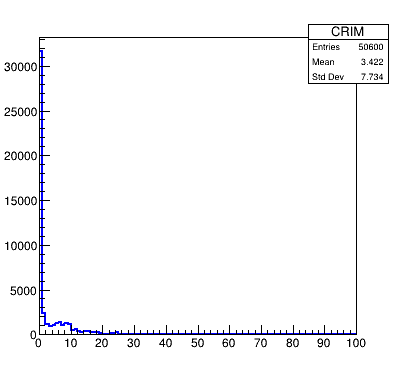

In [3]:
# Let's see how the data looks like first
hists = dict()
hists["CRIM"] = TH1D("CRIM", "", 100, 0., 100.)
hists["ZN"] = TH1D("ZN", "", 100, 0., 100.)
hists["INDUS"] = TH1D("INDUS", "", 30, 0., 30.)
hists["CHAS"] = TH1D("CHAS", "", 100, 0., 1.)
hists["NOX"] = TH1D("NOX", "", 100, 0., 1.)
hists["RM"] = TH1D("RM", "", 100, 0., 10.)
hists["AGE"] = TH1D("AGE", "", 140, 0., 140.)
hists["DIS"] = TH1D("DIS", "", 15, 0., 15.)
hists["RAD"] = TH1D("RAD", "", 25, 0., 25.)
hists["TAX"] = TH1D("TAX", "", 720, 0., 720.)
hists["PTRATIO"] = TH1D("PTRATIO", "", 25, 0., 25.)
hists["B"] = TH1D("B", "", 600, 0., 600.)
hists["LSTAT"] = TH1D("LSTAT", "", 40, 0., 40.)
hists["MEDV"] = TH1D("MEDV", "", 50, 0., 50.)

for i in range(len(cols)):
    feature = cols[i]
    for idx in confused_data.index:
        hists[feature].Fill(confused_data.loc[idx, feature])
        hists[feature].SetLineColor(4)
        hists[feature].SetLineWidth(2)

# correlation matrix
data = np.vstack([confused_data.iloc[:, i].to_numpy() for i in range(len(cols))])
corr = np.corrcoef(data)
hist_corr = TH2D("Correlation Matrix", "", 14, 0., 14., 14, 0., 14.)
hist_corr.SetStats(0)
for i in range(14):
    for j in range(14):
        hist_corr.Fill(i, j, corr[i][j])

cvs = TCanvas("cvs", "", 400, 400)
cvs.cd()
hists["CRIM"].Draw("hist")
#hist_corr.Draw("colz")
cvs.Draw()

In [4]:
# bounds should consider physical meanings of variables
# no cut for MEDV, we have to expect the value
lower_bounds = {
    "CRIM": 0.,
    "ZN": 0.,
    "INDUS": 0.,
    "CHAS": 0,
    "NOX": 0.3,
    "RM": 4.,
    "AGE": 0.,
    "DIS": 1., 
    "RAD": 0., 
    "TAX": 100.,
    "PTRATIO": 10., 
    "B": 300., 
    "LSTAT": 0.,
    "MEDV": 0.,
}
upper_bounds = {
    "CRIM": 20.,
    "ZN": 100.,
    "INDUS": 30.,
    "CHAS": 1,
    "NOX": 0.9,
    "RM": 9.,
    "AGE": 100.,
    "DIS": 12., 
    "RAD": 25., 
    "TAX": 750.,
    "PTRATIO": 25., 
    "B": 420.,
    "LSTAT": 40., 
    "MEDV": 50.,
}

In [5]:
fixed_outlier_data = confused_data.copy()

for feature in cols:
    for idx in confused_data.index:
        lower = lower_bounds[feature]
        upper = upper_bounds[feature]

        # CHAS should be 0 or 1, round the value
        # RAD should be an ingeger index between 0 and 24, change float to int
        if feature == "CHAS":
            fixed_outlier_data.loc[idx, "CHAS"] = int(round(confused_data.loc[idx, "CHAS"]))
        elif feature == "RAD":
            fixed_outlier_data.loc[idx, "RAD"] = int(confused_data.loc[idx, "RAD"])
        else:
            pass
        
        # -1 will be also fixed
        if not (lower <= confused_data.loc[idx, feature] and confused_data.loc[idx, feature] <= upper):
            fixed_outlier_data.loc[idx, feature] = np.nan
fixed_missing_data = fixed_outlier_data.interpolate(method="linear") 
preprocessed_data = fixed_missing_data.copy()   # will use this one


In [6]:
# Divide train and test dataset
shuffled_data =preprocessed_data.sample(frac=1).reset_index(drop=True)
train_ratio = 0.7
cut = int(len(shuffled_data)*train_ratio)
train_data = shuffled_data.loc[:cut, :].to_numpy()
test_data =  shuffled_data.loc[cut:, :].to_numpy()

In [7]:
# Split a dataset based on an attribute and an attribute value
# implement a split method that seperate the dataset into the left branch and the right branch
def branch_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] > value:
            right.append(row)
        else:
            left.append(row)
        # todo code
    return left, right

# implement the standard deviation method to select the splitting point
def std_index(groups, total):
    # get total
    # use MEDV for learning 
    if len(groups[0]) == 0 or len(groups[1]) == 0:
        return 0.
    left_and_right = np.array(groups[0][-1] + groups[1][-1])
    left = np.array(groups[0][-1])
    right = np.array(groups[1][-1])
    all_std = np.var(left_and_right)*len(left_and_right)
    left_std = np.var(left)*len(left)
    right_std = np.var(right)*len(right)
    s_total = all_std - (left_std+right_std)
    return s_total

# Select the best split point for a dataset
def get_split(dataset, c_idx=None):
    dt_length = len(dataset)
    b_index, b_value, b_score, b_groups = -1, -1., 0., None
    # loop over this column index to find split points
    if c_idx is None:
        c_idx = list(range(len(dataset[0])-1));
    for index in c_idx:
        for row in dataset:
            # get left | right at the current row-index
            groups = branch_split(index, row[index], dataset)
            std_score = std_index(groups, dt_length)
            matching_criteria = False
            if std_score > b_score:
                matching_criteria = True
            if matching_criteria:
                b_index, b_value, b_score, b_groups = index, row[index], b_score, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [8]:
# Create a terminal node value 
# generate the prediction result if the tree reaches to this leaf
def to_terminal(group):
    labels = [row[-1] for row in group]
    # implement the aggregation method => make prediction
    outputs = np.mean(labels)
    return outputs

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth, c_idx=None):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, c_idx)
        split(node['left'], max_depth, min_size, depth+1, c_idx)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right, c_idx)
        split(node['right'], max_depth, min_size, depth+1, c_idx)

# Build a decision tree
def build_tree(train, max_depth, min_size, c_idx=None):
    root = get_split(train, c_idx)
    split(root, max_depth, min_size, 1, c_idx)
    return root
 
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size, c_idx=None):
    tree = build_tree(train, max_depth, min_size, c_idx)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return (predictions)


In [9]:
# random forest implementation
# 1. implement a shuffle method to shuffle train set
# 2. implement a feature random seletion method for each tree, by that it can split branches
# 3. implement an ensemble method to aggregate the predicted results

def random_forest(n_trees, train_set, test_set, max_depth, min_size, n_features=5):
    np.random.seed(12)
    predictions = []
    
    for _ in range(n_trees):
        features = list(range(13))
        random.shuffle(features)
        features = features[0:n_features]
        predictions.append(decision_tree(train_set, test_set, max_depth, min_size, features))
    # todo code
    # hint: create multiple decision trees
    # aggregate their prediction results => final results
    predictions = np.mean(predictions, axis=0)
    return predictions

In [10]:
X_train, Y_train = train_data[:, :-1], train_data[:, -1]
X_test, Y_test = test_data[:, :-1], test_data[:, -1]

In [16]:
X_train_small, Y_train_small = X_train[0:5000], Y_train[0:5000]
X_test_small, Y_test_small = X_test[5000:5010], Y_test[5000:5010]

predicted_dt = decision_tree(X_train_small, X_test_small, 5, 10, [4, 6, 10, 11, 12])
predicted_rf = random_forest(10, X_train_small, X_test_small, 5, 10, 5)
print(Y_test_small)
print(predicted_dt)
print(predicted_rf)
print("mae loss for decision tree: {}".format(round(mae(Y_test_small, predicted_dt), 2)))
print("mae loss for random forest: {}".format(round(mae(Y_test_small, predicted_rf), 2)))

[35.62262976 22.94141708 24.30569493 29.55880452 15.91640887 20.3239868
 24.00490461 31.85554236 13.55655332 18.33037185]
[6.290615833790828, 8.641555634884357, 6.290615833790828, 3.615823643712046, 18.300349750757235, 9.839431670391315, 6.290615833790828, 3.615823643712046, 21.84959751849114, 11.751916726893015]
[ 9.48677476  8.74232288 10.31353094  9.62997267 15.36710558 10.530207
 14.32610523 10.12553679 12.25361714 14.57126824]
mae loss for decision tree: 16.13
mae loss for random forest: 12.11


In [17]:
dict_mae = dict()
for comb in list(combinations(list(range(13)), 5)):
    regressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features=5).fit(X_train, Y_train)
    Y_pred = regressor.predict(X_test)
    mae_loss = mae(Y_pred, Y_test)
    dict_mae[comb] = mae_loss
sorted_dict_mae = sorted(dict_mae.items(), key=lambda x: x[1])
n = 0
for pair in sorted_dict_mae:
    n += 1
    if n > 10:
        break
    print(pair[0], pair[1])

(2, 3, 6, 10, 11) 1.9111718236151074
(1, 4, 7, 9, 11) 1.9276455463099305
(3, 5, 6, 11, 12) 1.9307805991202553
(0, 1, 3, 5, 9) 1.9322811233029964
(5, 6, 7, 9, 12) 1.9354594146407909
(0, 1, 4, 5, 10) 1.9386832030212755
(0, 2, 4, 9, 12) 1.9491011432377712
(4, 5, 8, 10, 12) 1.9539872998639958
(1, 5, 7, 9, 11) 1.958080878005112
(1, 2, 4, 8, 9) 1.9584213504028158


In [18]:
# define decision tree regressor
regressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, max_features=5).fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mae_loss = mae(Y_pred, Y_test)
print("mae loss of decision tree:%.2f" % mae_loss)


mae loss of decision tree:2.25


In [19]:
# define random forest regressor
regressor = RandomForestRegressor(n_estimators=10, max_depth=5, min_samples_leaf=10, max_features=5).fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
mae_loss = mae(Y_pred, Y_test)
print("mae loss of random forest:%.2f" % mae_loss)

mae loss of random forest:1.69


### Feature importance
RM $\rightarrow$ LSTAT $\rightarrow$ INDUS $\rightarrow$ NOX $\rightarrow$ DIS

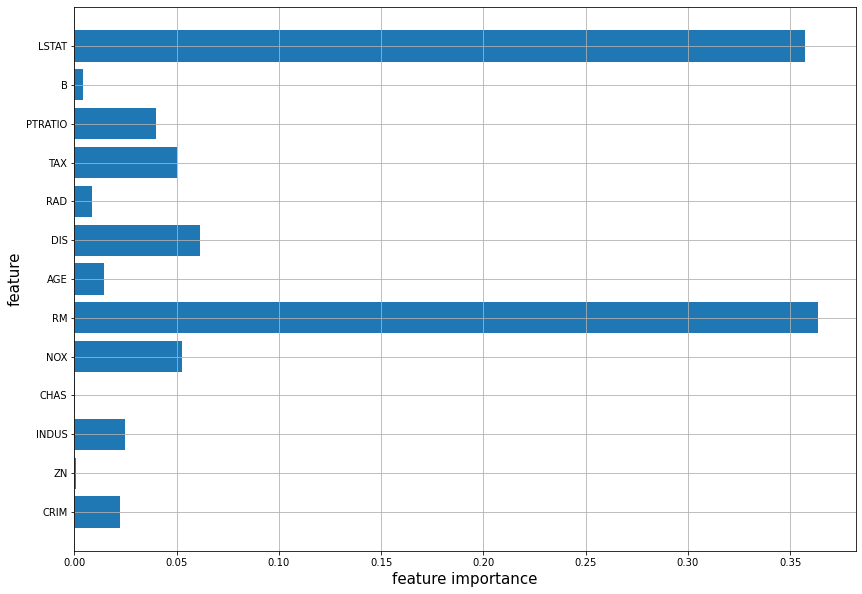

In [20]:
n_features = X_train.shape[1]
index = np.arange(n_features)
plt.figure(figsize=(14, 10))
plt.grid(True)
plt.barh(index, regressor.feature_importances_, align='center')
plt.yticks(index, cols[:-1])
plt.ylim(-1, n_features)
plt.xlabel("feature importance", size=15)
plt.ylabel("feature", size=15)
plt.show()
